In [1]:
# # Bank Reviews Sentiment Analysis
# This notebook analyzes sentiment of bank reviews stored in Oracle Database
# Import required libraries
import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# ## 1. Connect to Oracle Database
# Database connection function
def get_db_connection():
    dsn = cx_Oracle.makedsn("localhost", 1521, service_name="XEPDB1")
    return cx_Oracle.connect(user="bank_review", password="DB12345", dsn=dsn)


# Test connection
try:
    conn = get_db_connection()
    print("Successfully connected to Oracle Database")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")


Successfully connected to Oracle Database


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# ## 2. Load Review Data

def load_reviews(limit=1000):
    """Load reviews from Oracle database"""
    query = f"""
    SELECT r.review_id, b.bank_name, r.review_text, r.rating, r.review_date, r.source
    FROM reviews r
    JOIN banks b ON r.bank_id = b.bank_id
    WHERE ROWNUM <= {limit}
    """
    
    with get_db_connection() as conn:
        with conn.cursor() as cursor:
            cursor.execute(query)
            columns = [col[0].lower() for col in cursor.description]
            data = cursor.fetchall()
    
    return pd.DataFrame(data, columns=columns )
# Load the data
#reviews_df = load_reviews()
#print(f"Loaded {len(reviews_df)} reviews")
#reviews_df.head()
def load_reviews(limit=1000):
    """Load reviews from Oracle database with proper LOB handling"""
    query = f"""
    SELECT r.review_id, b.bank_name, r.review_text, r.rating, r.review_date, r.source
    FROM reviews r
    JOIN banks b ON r.bank_id = b.bank_id
    WHERE ROWNUM <= {limit}
    """
    
    with get_db_connection() as conn:
        # Fetch all data before closing connection
        with conn.cursor() as cursor:
            cursor.execute(query)
            columns = [col[0].lower() for col in cursor.description]
            # Convert LOBs to strings immediately
            data = [
                (
                    row[0],  # review_id
                    row[1],  # bank_name
                    str(row[2]) if row[2] else None,  # Convert CLOB to string
                    row[3],  # rating
                    row[4],  # review_date
                    row[5]   # source
                )
                for row in cursor
            ]
    
    return pd.DataFrame(data, columns=columns)

# Load the data safely
reviews_df = load_reviews(limit=1000)
print(f"Successfully loaded {len(reviews_df)} reviews")

# Display the first few rows
reviews_df.head()
                        

Successfully loaded 1000 reviews


,review_id,bank_name,review_text,rating,review_date,source
0,118,Commercial Bank of Ethiopia,it's easy and fast,5.0,2025-05-10,Google Play
1,119,Commercial Bank of Ethiopia,This app don't have self activation only you h...,1.0,2025-05-10,Google Play
2,120,Commercial Bank of Ethiopia,hello dearest CBE office personnel make some b...,5.0,2025-05-09,Google Play
3,121,Commercial Bank of Ethiopia,wow best application ever,5.0,2025-05-09,Google Play
4,122,Commercial Bank of Ethiopia,Am sorry but what does developer mode do to th...,1.0,2025-05-08,Google Play


In [3]:
# ## 3. Sentiment Analysis
def analyze_sentiment(text):
    """Perform sentiment analysis using TextBlob"""
    analysis = TextBlob(str(text))
    return {
        'polarity': analysis.sentiment.polarity,
        'subjectivity': analysis.sentiment.subjectivity
    }

# Apply sentiment analysis
sentiment_results = reviews_df['review_text'].apply(analyze_sentiment).apply(pd.Series)
reviews_df = pd.concat([reviews_df, sentiment_results], axis=1)

# Classify sentiment
reviews_df['sentiment_label'] = reviews_df['polarity'].apply(
    lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral'
)

# Preview results
reviews_df[['bank_name', 'rating', 'polarity', 'sentiment_label']].head(10)


,bank_name,rating,polarity,sentiment_label
0,Commercial Bank of Ethiopia,5.0,0.316667,positive
1,Commercial Bank of Ethiopia,1.0,-0.300000,negative
2,Commercial Bank of Ethiopia,5.0,0.300000,positive
3,Commercial Bank of Ethiopia,5.0,0.550000,positive
4,Commercial Bank of Ethiopia,1.0,-0.266667,negative
5,Commercial Bank of Ethiopia,5.0,0.000000,neutral
6,Commercial Bank of Ethiopia,1.0,0.000000,neutral
7,Commercial Bank of Ethiopia,5.0,0.375000,positive
8,Commercial Bank of Ethiopia,5.0,0.600000,positive
9,Commercial Bank of Ethiopia,5.0,0.000000,neutral


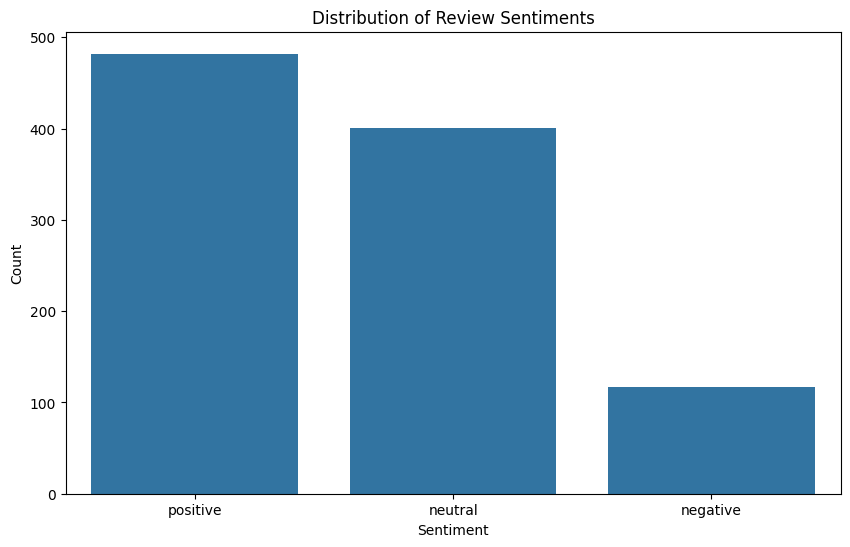

In [4]:
# Sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=reviews_df, x='sentiment_label', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

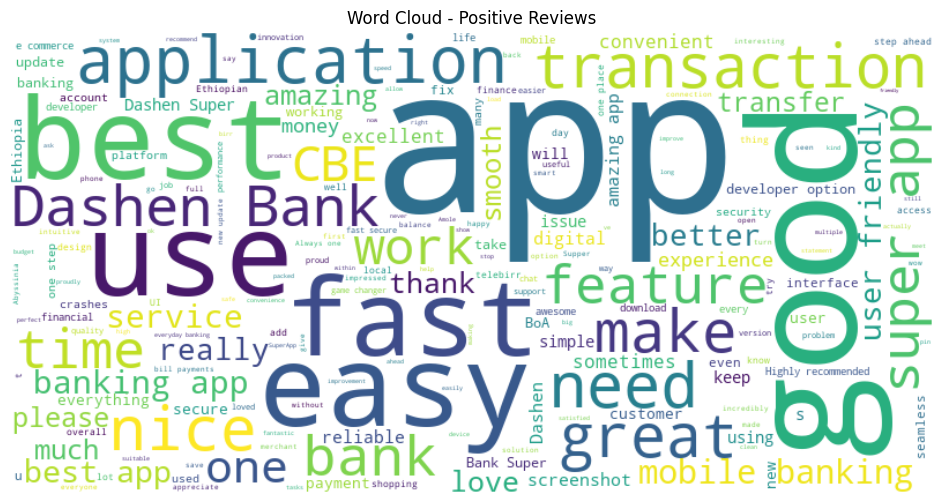

In [5]:
# ## 5. Text Analysis
# Word Cloud for Positive Reviews
positive_text = ' '.join(reviews_df[reviews_df['sentiment_label'] == 'positive']['review_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')
plt.show()

In [7]:
# Most Common Words
def get_top_words(text_series, n=20):
    stop_words = set(stopwords.words('english'))
    words = ' '.join(text_series).lower().split()
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    return Counter(filtered_words).most_common(n)


In [9]:
# Top words in negative reviews
negative_words = get_top_words(reviews_df[reviews_df['sentiment_label'] == 'negative']['review_text'])
pd.DataFrame(negative_words, columns=['Word', 'Count']).head(10)

,Word,Count
0,app,59
1,worst,25
2,banking,18
3,bank,14
4,even,12
5,mobile,12
6,ever,11
7,slow,10
8,working,9
9,please,9


In [10]:
# ## 7. Key Findings Report
# Generate summary statistics
summary = reviews_df.groupby('bank_name').agg({
    'rating': 'mean',
    'polarity': 'mean',
    'review_id': 'count'
}).rename(columns={
    'rating': 'avg_rating',
    'polarity': 'avg_sentiment',
    'review_id': 'review_count'
}).sort_values('avg_sentiment', ascending=False)

print("## Bank Review Sentiment Analysis Report ##")
print("\nKey Statistics:")
print(summary)

best_bank = summary.idxmax()['avg_sentiment']
worst_bank = summary.idxmin()['avg_sentiment']
print(f"\nMost Positive Bank: {best_bank}")
print(f"Least Positive Bank: {worst_bank}")

correlation = reviews_df['rating'].corr(reviews_df['polarity'])
print(f"\nCorrelation between star ratings and sentiment: {correlation:.2f}")

## Bank Review Sentiment Analysis Report ##

Key Statistics:
                             avg_rating  avg_sentiment  review_count
bank_name                                                           
Dashen Bank                    4.533898       0.331112           236
Commercial Bank of Ethiopia    4.090667       0.313515           375
Bank of Abyssinia              2.552699       0.030944           389

Most Positive Bank: Dashen Bank
Least Positive Bank: Bank of Abyssinia

Correlation between star ratings and sentiment: 0.50
